# Q.1. チャネル入れ替え

画像を読み込み、RGBをBGRの順に入れ替えよ。

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

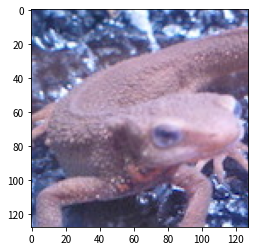

In [2]:
# 画像読み込み
img = cv2.imread("imori.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

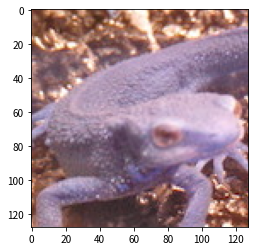

True

In [9]:
# チャネル入れ替え
img_out = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
plt.show()

# 画像書き出し
cv2.imwrite("out.jpg", img_out)

# Q.2. グレースケール化

画像をグレースケールにせよ。 グレースケールとは、画像の輝度表現方法の一種であり下式で計算される。

Y = 0.2126 R + 0.7152 G + 0.0722 B

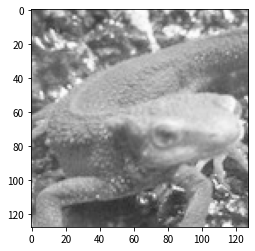

In [5]:
def gen_grayscale(img):
    green = img[:,:,0]
    blue = img[:,:,1]
    red = img[:,:,2]
    
    gray =  0.2126*red + 0.7152*green + 0.0722*blue
    
    gray = gray.astype(np.uint8)
    return gray

img_out = gen_grayscale(img)
plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
plt.show()

# Q.3. 二値化
画像を二値化せよ。 二値化とは、画像を黒と白の二値で表現する方法である。 ここでは、グレースケールにおいて閾値を128に設定し、下式で二値化する。

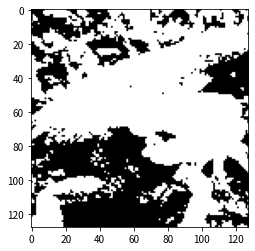

In [26]:
def gen_binary(img,th=128):
    """ generate binary image 
    
    Args:
    img : image
    th : threshold
    """
    
    img[img<th] = 0
    img[img>=th] = 255
    
    return img

gray_scale_image = gen_grayscale(img)
binary_image = gen_binary(gray_scale_image)
plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))
plt.show()    

# Q.4. 大津の二値化
大津の二値化を実装せよ。 大津の二値化とは判別分析法と呼ばれ、二値化における分離の閾値を自動決定する手法である。 これはクラス内分散とクラス間分散の比から計算される。

best threshold =146


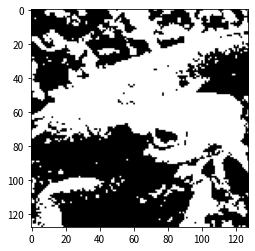

In [25]:
def gen_ootu_binary(img):
    sb_list = []
    img_flat = img.flatten() # 画像を1次元配列に変換
    n = len(img_flat) # データ数
    
    for th in range(0,256):
        data_class0 = img_flat[img_flat<th]
        data_class1 = img_flat[img_flat>=th]
        
        w0 = len(data_class0)/n # クラス0のデータが占める割合
        w1 = len(data_class1)/n # クラス1のデータが占める割合
        
        # class0の分散
        if len(data_class0)!=0:
            m0 = np.mean(data_class0)
            v0 = np.var(data_class0)
        else:
            m0=0
            v0=0
            
        # class1の分散
        if len(data_class1)!=0:
            m1 = np.mean(data_class1)
            v1 = np.var(data_class1)
        else:
            m1=0
            v1=0        
            
        sb = w0*w1*(m0-m1)**2
        sb_list.append(sb)
        
    best_th = np.argmax(sb_list)
    print("best threshold =%d"%(best_th))
    return gen_binary(img,best_th)
    
gray_scale_image = gen_grayscale(img)
binary_image = gen_ootu_binary(gray_scale_image)
plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))
plt.show()    

# Q.5. HSV変換
HSV変換を実装して、色相Hを反転せよ。

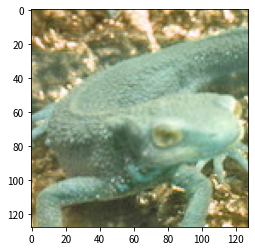

In [40]:
def rgb2hsv(img):
    img = img/255
    hsv = np.zeros_like(img, dtype=np.float32)
    
    max_v = np.max(img,axis=2)
    min_v = np.min(img,axis=2)
    min_arg = np.argmin(img,axis=2)
    
    # Hの計算 ...は次元を省略して書く記法
    hsv[...,0][np.where(max_v==min_v)]=0
    ## if min == B
    ind = np.where(min_arg == 0)
    hsv[..., 0][ind] = 60 * (img[..., 1][ind] - img[..., 2][ind]) / (max_v[ind] - min_v[ind]) + 60
    ## if min == R
    ind = np.where(min_arg == 2)
    hsv[..., 0][ind] = 60 * (img[..., 0][ind] - img[..., 1][ind]) / (max_v[ind] - min_v[ind]) + 180
    ## if min == G
    ind = np.where(min_arg == 1)
    hsv[..., 0][ind] = 60 * (img[..., 2][ind] - img[..., 0][ind]) / (max_v[ind] - min_v[ind]) + 300
    
    # Sの計算
    hsv[...,1] = max_v-min_v
    
    # Vの計算
    hsv[...,2] = max_v
    
    return hsv
    
def hsv2rgb(img):
    max_v = np.max(img,axis=2)
    min_v = np.min(img,axis=2)
    rgb = np.zeros_like(img)
    
    C = img[...,1]
    Hdash = img[...,0]/60
    X = C * (1 - np.abs( Hdash % 2 - 1))
    Z = np.zeros_like(img[...,0])
    
    vals = [[Z,X,C], [Z,C,X], [X,C,Z], [C,X,Z], [C,Z,X], [X,Z,C]]

    for i in range(6):
        ind = np.where((i <= Hdash) & (Hdash < (i+1)))
        rgb[..., 0][ind] = (img[...,2] - C)[ind] + vals[i][0][ind]
        rgb[..., 1][ind] = (img[...,2] - C)[ind] + vals[i][1][ind]
        rgb[..., 2][ind] = (img[...,2] - C)[ind] + vals[i][2][ind]
    
    rgb[np.where(max_v == min_v)] = 0
    rgb = np.clip(rgb, 0, 1)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

out1 = rgb2hsv(img)
# Hを180°反転
out1[...,0] = (out1[...,0]+180)%360
out2 = hsv2rgb(out1)
plt.imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB))
plt.show()    

# Q.6. 減色処理
ここでは画像の値を256^3から4^3、すなわちR,G,B in {32, 96, 160, 224}の各4値に減色せよ。 これは量子化操作である。 各値に関して、以下の様に定義する。

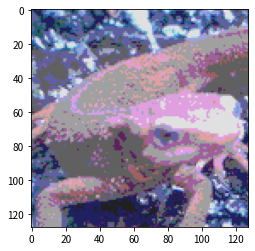

In [45]:
def substract_color(img):
    out = img.copy()

    out = out // 64 * 64 + 32 # 整数の割り算

    return out

out = substract_color(img)
out = out.astype(np.uint8)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.show()    

# 平均プーリング
ここでは画像をグリッド分割(ある固定長の領域に分ける)し、かく領域内(セル)の平均値でその領域内の値を埋める。 このようにグリッド分割し、その領域内の代表値を求める操作はPooling(プーリング) と呼ばれる。 これらプーリング操作はCNN(Convolutional Neural Network) において重要な役割を持つ。

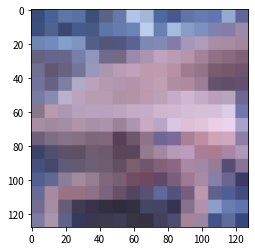

In [70]:
def average_pooling(img):
    out = np.zeros_like(img)
    grid_size = 8
    img_width,img_height,layer = img.shape
    for height in range(0,img_height,grid_size):
        for width in range(0,img_width,grid_size):
            for l in range(layer):
                out[height:height+grid_size,width:width+grid_size,l] = np.mean(img[height:height+grid_size,width:width+grid_size,l])
                
    return out.astype(np.uint8)

out = average_pooling(img)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.show()    

# Maxプーリング
ここでは平均値でなく最大値でプーリングせよ。

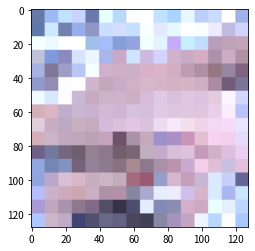

In [72]:
def max_pooling(img):
    out = np.zeros_like(img)
    grid_size = 8
    img_width,img_height,layer = img.shape
    for height in range(0,img_height,grid_size):
        for width in range(0,img_width,grid_size):
            for l in range(layer):
                out[height:height+grid_size,width:width+grid_size,l] = np.max(img[height:height+grid_size,width:width+grid_size,l])
                
    return out.astype(np.uint8)

out = max_pooling(img)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.show()    